# Lab 4-2. MLP MNIST classification

### 이번 실습은 Multi-layer perceptron 모델을 만들고 이를 이용해 MNIST dataset으로 classification을 진행해 봅니다.

### MNIST는 가장 유명한 머신러닝과 딥러닝 데이터 중 하나로 0~9 까지의 숫자 손글씨 데이터입니다.

### 10개의 class, 총 60000개의 data sample이 있으며 28 * 28 size의 이미지 데이터로, 우리는 MLP에 사용하기 위해 784 size의 벡터로 사용합니다.

### Pytorch tutorial 실습에서 보신 FashionMNIST는 MNIST와 같은 형태를 가진 옷  dataset이며 마찬가지로 torchvision에서 다운받아 사용이 가능합니다.

### torchvision에서 dataset을 얻어 dataloader를 만들고, 학습을 위한 반복문을 만들어 MLP를 사용해 보겠습니다.

### 또한 이론 수업에서는 아직 진행하지 않았지만 간단한 알고리즘을 이용해 모델을 학습까지 시켜보겠습니다.

### 이번 실습에서 사용할 패키지들은 다음과 같습니다.

- os
- numpy
- pytorch
- torchvision
- matplotlib


### Drive mount and package import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 4-2-1. Data Prepare

In [ ]:
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "data")
root

'/content/drive/MyDrive/Colab Notebooks/data'

In [ ]:
mnist_train = datasets.MNIST(
    root=root, 
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
    # 원핫 인코딩을 통해서 1과 8사이의 의미적 차이가 없어짐
    # 만약 하지 않는다면 1과 8은 7이라는 차이가 생겨버릴것임
) #, target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
mnist_test = datasets.MNIST(
    root=root, 
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
) #, target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Colab Notebooks/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Colab Notebooks/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Colab Notebooks/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Colab Notebooks/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/data/MNIST/raw



In [ ]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
sample_x, sample_y = mnist_train[0]
print(sample_x.shape)
print(sample_y)

torch.Size([1, 28, 28])
5


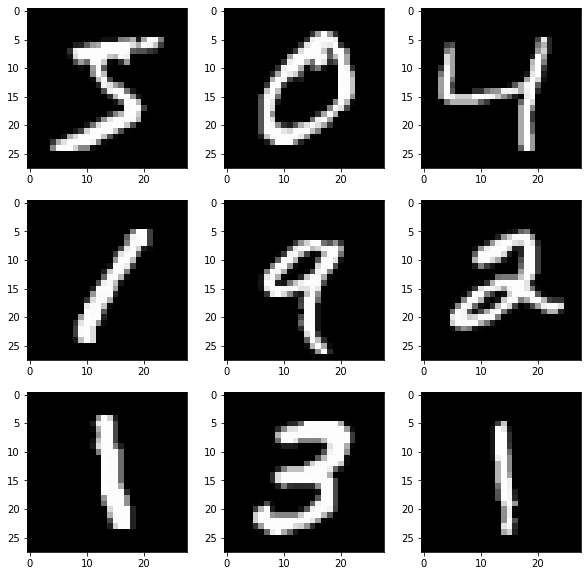

In [ ]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
  img = mnist_train[i][0]
  ax = fig.add_subplot(3, 3, i+1)
  ax.imshow(img.reshape(28, 28), cmap="gray")
fig.show()

In [ ]:
# 여러개의 batch중 몇개의 batch가 남을텐데 남은 batch로 오류가 날수 있기에 drop_last를 해줌
train_loader = DataLoader(dataset=mnist_train, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=64, shuffle=False, drop_last=True)

## 4-2-2. Model Build


In [ ]:
class LionMNISTClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10),
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
mlp = LionMNISTClassifier().to(device)
mlp

LionMNISTClassifier(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
#nn.CrossEntropyLoss() 에 소프트 맥스 포함
loss_fn = nn.CrossEntropyLoss()

In [ ]:
mlp.parameters()

<generator object Module.parameters at 0x7f7f7d611d50>

In [ ]:
optim = torch.optim.SGD(mlp.parameters(), lr=0.001)

## 4-2-3. Train

In [ ]:
num_epochs = 20

In [ ]:
train_history = {"loss": [], "acc": []}
for e in range(num_epochs):
  print(f"Epoch: {e} start.")
  epoch_loss, epoch_acc = 0, 0
  size = len(train_loader.dataset)
  for b, (x, y) in enumerate(train_loader):
    x.to(device)
    y.to(device)

    pred = mlp(x)
    loss = loss_fn(pred, y)
    # 이전 batch의 그래디언트 값 날리기!
    optim.zero_grad()
    loss.backward()
    optim.step()

    loss = loss.to("cpu").item()
    acc = (pred.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    if b % 200 == 0:
      print(f"loss: {loss:>7f}, acc: {acc:>4f} [{b * len(x)}/{size}]")

    epoch_loss += loss
    epoch_acc += acc

  train_history["loss"].append(epoch_loss / len(train_loader))
  train_history["acc"].append(epoch_acc / len(train_loader))


Epoch: 0 start.
loss: 2.302416, acc: 0.125000 [0/60000]
loss: 2.291595, acc: 0.140625 [12800/60000]
loss: 2.283737, acc: 0.156250 [25600/60000]
loss: 2.279562, acc: 0.125000 [38400/60000]
loss: 2.267592, acc: 0.312500 [51200/60000]
Epoch: 1 start.
loss: 2.252550, acc: 0.546875 [0/60000]
loss: 2.245447, acc: 0.500000 [12800/60000]
loss: 2.244198, acc: 0.500000 [25600/60000]
loss: 2.221585, acc: 0.640625 [38400/60000]
loss: 2.206742, acc: 0.625000 [51200/60000]
Epoch: 2 start.
loss: 2.190384, acc: 0.625000 [0/60000]
loss: 2.180185, acc: 0.718750 [12800/60000]
loss: 2.180788, acc: 0.625000 [25600/60000]
loss: 2.135890, acc: 0.656250 [38400/60000]
loss: 2.076876, acc: 0.750000 [51200/60000]
Epoch: 3 start.
loss: 2.047582, acc: 0.703125 [0/60000]
loss: 2.082144, acc: 0.671875 [12800/60000]
loss: 2.029853, acc: 0.687500 [25600/60000]
loss: 1.893045, acc: 0.750000 [38400/60000]
loss: 1.942748, acc: 0.640625 [51200/60000]
Epoch: 4 start.
loss: 1.798686, acc: 0.750000 [0/60000]
loss: 1.918615, 

In [ ]:
print(f"Loss history: {train_history['loss']}")
print(f"Acc history: {train_history['acc']}")

Loss history: [2.2828226969870586, 2.2293715064782598, 2.1441094249391504, 1.9955982005456214, 1.7563672259115994, 1.4487040653554455, 1.1594934158798471, 0.9477400896134474, 0.8048332561296485, 0.7068034438466059, 0.6358990039171506, 0.5835917099690107, 0.5429606507974603, 0.51112054703457, 0.4853421945995557, 0.46409150574797625, 0.44647588366950713, 0.4315106520785084, 0.41857329092864165, 0.4073955834929691]
Acc history: [0.19377001067235858, 0.5779582443970117, 0.690184765208111, 0.7079108858057631, 0.7280382870864461, 0.7436132604055496, 0.7710278815368197, 0.7995931163287087, 0.8188700640341515, 0.8332110458911419, 0.8449839914621131, 0.853721985058698, 0.8613260405549626, 0.8673959445037354, 0.8722818836712913, 0.8766842315901814, 0.880753068303095, 0.8834545090715048, 0.8860558964781217, 0.8888907417289221]


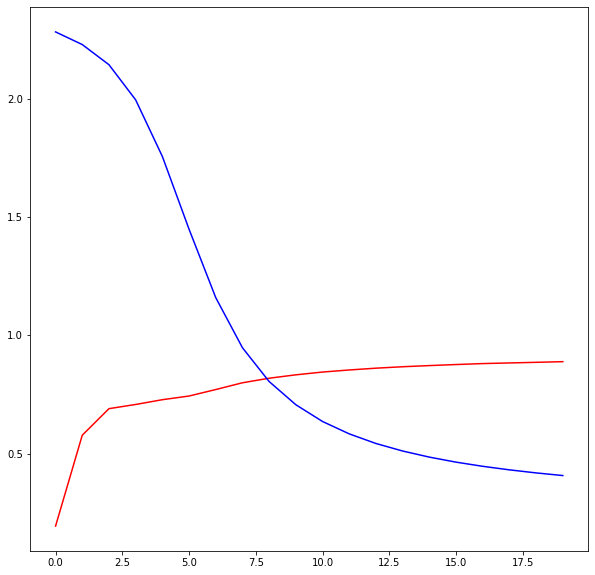

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_history["acc"], color="red", label="acc")
ax.plot(train_history["loss"], color="blue", label="loss")
fig.show()

## 4-2-4. Test

In [ ]:
print("Test start.")
test_loss, test_acc = 0, 0
size = len(test_loader.dataset)
# 그래디언트 추적 x
with torch.no_grad():
  for b, (x, y) in enumerate(test_loader):
    x.to(device)
    y.to(device)

    pred = mlp(x)
    test_loss += loss_fn(pred, y).to("cpu").item()
    test_acc += (pred.argmax(1) == y).type(torch.float).to("cpu").mean().item()

  test_loss /= len(test_loader)
  test_acc /= len(test_loader)

print(f"test loss: {test_loss:>7f}, test_acc: {test_acc:>4f}.")

Test start.
test loss: 0.386942, test_acc: 0.894131.
